0.0802866618942 {'5%': array([ 0.04921392]), '50%': array([ 0.07851234]), '95%': array([ 0.10583267])} 769


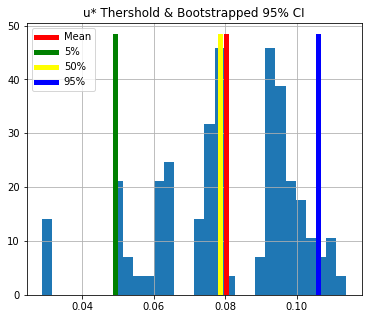

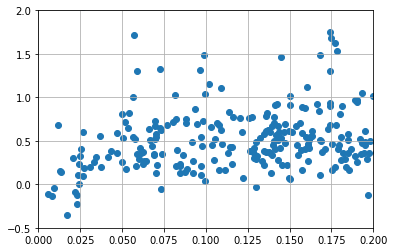

In [5]:
import os
import scipy.stats as stats
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime as dt
import pytz
from sklearn.utils import resample
%matplotlib inline
import warnings

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor as MPR
from sklearn.preprocessing import Normalizer,StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from scipy.optimize import curve_fit
from matplotlib.ticker import NullFormatter
import Data_Processor as DP
import importlib
importlib.reload(DP)
# warnings.filterwarnings('ignore')
Root = 'C:/FishIsland_2017/'
FluxFolder='FluxResults/ProperWindSpeeds/'

TenHz_Path = Root+FluxFolder+'10Hz/eddypro_10Hz_full_output_2018-03-25T172145_adv.csv'
OneHz_Path = Root+FluxFolder+'1Hz/eddypro_1Hz_full_output_2018-03-25T142146_adv.csv'

Met_Path = Root+'MetStationData/CR1000_ClimateData_Updated.txt'
Soil_Path = Root+'SoilStationData/Soil_Data.csv'


Comp = DP.Compile([TenHz_Path,OneHz_Path],Met_Path,Soil_Path)

Drop = [['2017-06-01 15:00:00','2017-06-23 15:00:00'],
['2017-08-28 00:00:00','2017-09-11 16:00:00'],
['2017-09-12 07:30:00','2017-09-12 15:00:00']]
Var = ['All','co2_flux','co2_flux']
for drop,var in zip(Drop,Var):
    Comp.Date_Drop(drop,Vars=var)
    
Comp.Rain_Check([.5,0])

# Comp.Wind_Bins(30)
# Comp.PPFD_Bins(100)
    
Comp.QC_Check(2)
Comp.Spike_Removal(z_thresh=5.5)
Comp.StorageCorrection()
Comp.Wind_Filter(30)
Comp.ustar_Bins(30,{'Var':'PPFD_Avg','Thresh':10},{'Var':'co2_flux','Plot':True},
                {'Repetitions':100,'n_samples':10000})
plt.figure()
plt.scatter(Comp.uFilterData['u*'],Comp.uFilterData['fco2'])
plt.ylim(-.5,2)
plt.xlim(0,.2)
plt.grid()

print(Comp.uThresh,Comp.Pct,Comp.uThresh_SampSize)

In [6]:
Comp.Ustar_Drop()
Comp.CustomVars()
Comp.Fco2_Fill('PPFD_Avg','AirTC_Avg')
Vars=['H','LE','fco2','fch4','wind_speed','air_pressure','AirTC_Avg','NR_Wm2_Avg','PPFD_Avg','Rain_mm_Tot','Table_1','Temp_2_5_1','Temp_15_1',
      'VWC_1','Active_Layer_1','24H Rain','Wtr Tbl Trnd','ET']
Aliases=['H','LE','Fco2','Fch4','Wind Spd','air pressure','Ta','Rn','PPFD','Rain','Water Table','Ts 2.5 cm','Ts 15 cm',
         'VWC','Active Layer','24H Rain','Wtr Tbl Trnd','ET']
Comp.Write(Root,Vars,Aliases)
Data = Comp.Data

0.13345087042752116
68
-0.4679018173014322


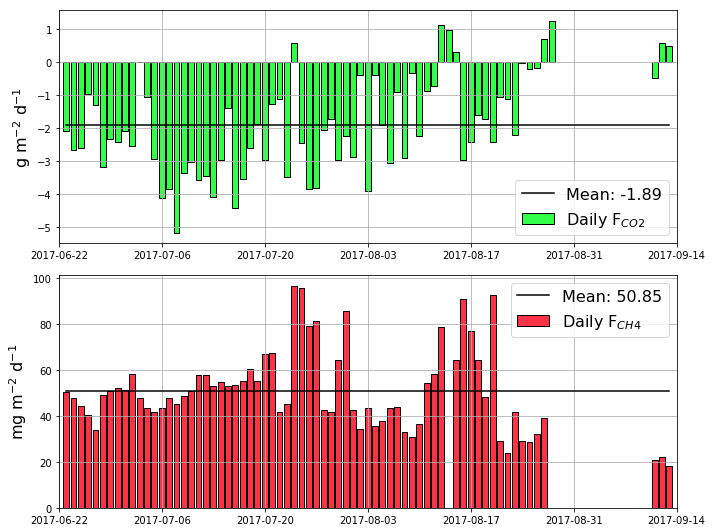

In [7]:
Green = (0,1,.1,.8)
Red = (1,0,.1,.8)

Daily = Data.resample('D').mean()
fig,ax = plt.subplots(2,1,figsize = (10,7.5))

Daily['fco2']=Daily['Fco2']* 1e-6 * 44.0095 *3600*24

Daily['fch4']=Daily['fch4']* 1e-3 * 16.04246 *3600*24

Mn = Daily['fch4'].mean()*28*1e-3+Daily['fco2'].mean()

print(-Mn*81/(365-81))
print(Daily['fch4'].count())
print(Daily['fch4'].mean()*28*1e-3+Daily['fco2'].mean())

ax[0].bar(Daily.index,Daily['fco2'],color = Green,edgecolor = 'black',label='Daily F$_{CO2}$')
ax[0].set_xlim('2017-06-22','2017-09-14')
Daily['Mean']=Daily['fco2'].mean()
ax[0].plot(Daily['Mean'],color='black',label = 'Mean: '+ str(np.round(Daily['Mean'].mean(),2)))
ax[0].grid()
ax[0].set_ylabel('g m$^{-2}$ d$^{-1}$',fontsize = 16)
ax[0].legend(loc=4,fontsize = 16)


ax[1].bar(Daily.index,Daily['fch4'],color = Red,edgecolor = 'black',label = 'Daily F$_{CH4}$')
ax[1].set_xlim('2017-06-22','2017-09-14')
Daily['Mean']=Daily['fch4'].mean()
ax[1].plot(Daily['Mean'],color='black',label = 'Mean: ' + str(np.round(Daily['Mean'].mean(),2)))
ax[1].grid()
ax[1].set_ylabel('mg m$^{-2}$ d$^{-1}$',fontsize = 16)
ax[1].legend(loc = 1,fontsize = 16)

plt.tight_layout()
plt.savefig('C:/Users/wesle/CompsProj/GHG_Balance.png',dpi=500)
plt.show()

In [39]:
for root,Dir,files in (os.walk(Root+'TagluStationData/Daily/')):
    for i,file in enumerate(files):
        df = pd.read_excel(root+file,sheetname=[0],skiprows=[0,2,3])[0]
        df = df.set_index(pd.DatetimeIndex(df.TIMESTAMP))
        if i == 0:
            Daily = df
        else:
            Daily = Daily.append(df)
            


for root,Dir,files in (os.walk(Root+'TagluStationData/Hourly/')):
    for i,file in enumerate(files):
        df = pd.read_excel(root+file,sheetname=[0],skiprows=[0,1,3],na_values='NAN')[0]
        df = df.set_index(pd.DatetimeIndex(df.TIMESTAMP))
        for V in ['SoilMoist(1)','SoilMoist(2)','SoilMoist(3)','SoilMoist(4)','SoilMoist(5)','SoilMoist(6)']:
            df[V]=pd.to_numeric(df[V])
#         df[['SoilMoist(1)','SoilMoist(2)','SoilMoist(3)','SoilMoist(4)','SoilMoist(5)','SoilMoist(6)']] =\
#         pd.to_numeric(df[['SoilMoist(1)','SoilMoist(2)','SoilMoist(3)','SoilMoist(4)','SoilMoist(5)','SoilMoist(6)']])
        if i <= 5:
            df[['SoilMoist(1)','SoilMoist(2)','SoilMoist(3)']]*=100
        if i == 0:
            Hourly = df
        else:
            Hourly = Hourly.append(df)

Daily.loc[Daily['Snow_Depth']<0] = np.nan
Daily.loc[Daily['Snow_Depth']>1] = np.nan
Daily['Snow_Depth'] = Daily['Snow_Depth'].ffill()

             AirTemp  AirTemp_Avg  Net_LW_Wm2_Avg  Net_SW_Wm2_Avg  \
TIMESTAMP                                                           
2008-08-27  7.097909     7.051091      -20.904545       99.792727   
2008-08-28  5.224292     5.239625      -11.671042       35.566750   

            Net_Ttl_Rad_Avg  RECORD  Rainfall_Tot  SoilMoist(1)  SoilMoist(2)  \
TIMESTAMP                                                                       
2008-08-27        78.869455    22.0           0.0     28.481818     90.254545   
2008-08-28        23.899333    39.5           0.0     28.166667     90.254167   

            SoilMoist(3)  SoilMoist(4)  SoilMoist(5)  SoilMoist(6)    WindDir  \
TIMESTAMP                                                                       
2008-08-27     79.800000      0.126364      0.737364      0.808182  63.549091   
2008-08-28     80.254167      0.125917      0.734708      0.810542  42.937042   

             WindSpd  
TIMESTAMP             
2008-08-27  5.008091  
2008

Text(0.5,1,'Soil Moisture')

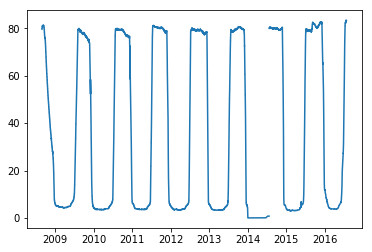

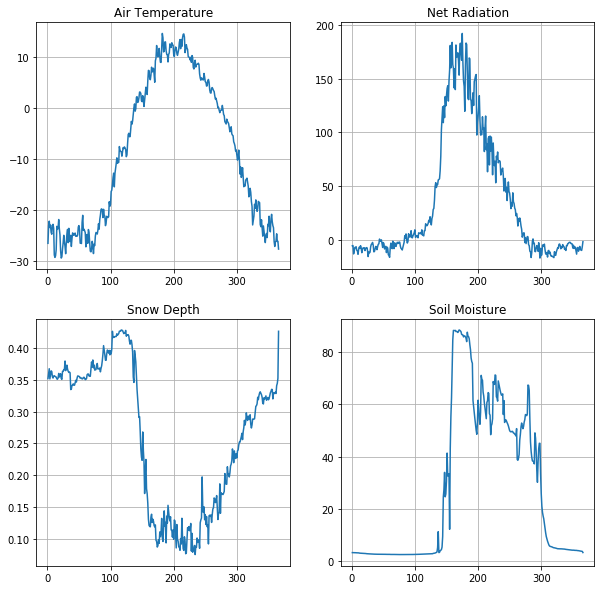

In [42]:
Daily.loc[Daily['Snow_Depth']<0] = np.nan
Daily.loc[Daily['Snow_Depth']>.7] = np.nan
Daily['Snow_Depth'].ffill()

print(Hourly.resample('D').mean().head(2))
Daily2=Hourly.resample('D').mean()
plt.plot(Hourly['SoilMoist(3)'])

Daily2=Daily2.groupby(Daily2.index.dayofyear).mean()
DailyDaily2=Daily.groupby(Daily.index.dayofyear).mean()
# print(Monthly)

# print(Daily.head())

fig,ax = plt.subplots(2,2,figsize=(10,10))

ax1 = ax[0,0]
ax2 = ax[0,1]
ax3 = ax[1,0]
ax4 = ax[1,1]

ax1.plot(Daily2['AirTemp'])
ax1.grid()
ax1.set_title('Air Temperature')

ax2.plot(Daily2['Net_Ttl_Rad_Avg'])
ax2.grid()
ax2.set_title('Net Radiation')

ax3.plot(DailyDaily2['Snow_Depth'])
ax3.set_title('Snow Depth')
# ax3.set_ylim(0,1)
ax3.grid()

# ax4.plot(Daily2['SoilMoist(1)'])
# ax4.plot(Daily2['SoilMoist(2)'])
ax4.plot(Daily2['SoilMoist(1)'])
ax4.grid()
ax4.set_title('Soil Moisture')

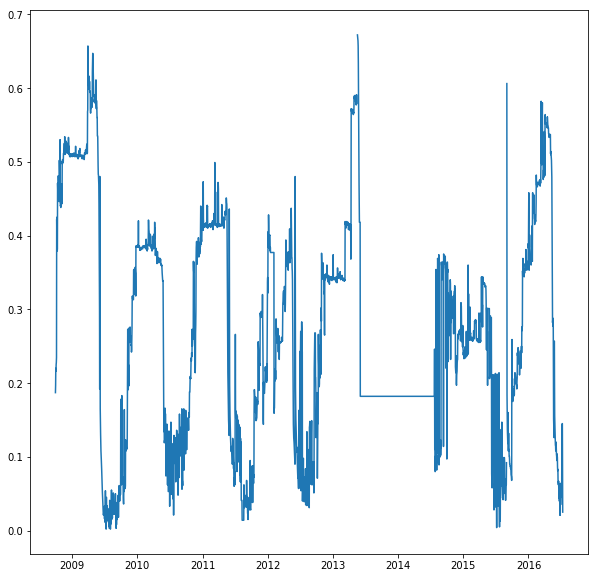

In [43]:
plt.figure(figsize=(10,10))
plt.plot(Daily['Snow_Depth'])